In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import torch
import numpy as npset_alpha
from tqdm.auto import tqdm, trange
from collections import OrderedDict
import random
import numpy as np
import xgboost as xgb
import pandas as pd
from functools import reduce
from copy import deepcopy
import argparse
import shap
import matplotlib.pyplot as plt
from scipy.spatial import distance
from statsmodels.distributions.empirical_distribution import ECDF
import seaborn as sns 
import itertools
from scipy import stats
import time
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
import sys
try:
  from urllib import urlretrieve
except ImportError:
  from urllib.request import urlretrieve

In [ ]:
parser = argparse.ArgumentParser("")
parser.add_argument('--repeat',      type=int,   default=1000)
parser.add_argument('--save_dir',           type=str)
parser.add_argument('--rand_seed',          type=int,   default=-1)
parser.add_argument('--sampling_method', type=str,  default='uniform')
parser.add_argument('--num_sample_method', type=str,  default='uniform')
parser.add_argument('--dataset', type=str,  default='cifar100')
parser.add_argument('--setname', type=str,  default='x-test')
parser.add_argument('--keep_old', type=str,  default='all')
parser.add_argument('--max_sample',          type=int,   default=1000)
parser.add_argument('--step',          type=int,   default=10)
parser.add_argument('--n_trees',          type=int,   default=5000)
parser.add_argument('--max_depth',          type=int,   default=10)
parser.add_argument('--iteration',          type=int,   default=5)
parser.add_argument('--top_max',          type=int,   default=2000,   help='manual seed')
parser.add_argument('--top_min',          type=int,   default=80,   help='manual seed')
parser.add_argument('--top_list_acc', type=int, nargs='+', default=[2000, 667, 444, 296, 198])
parser.add_argument('--top_list_acc_delta', type=int, nargs='+', default=[10000, 8000, 6000, 4000, 2000])
parser.add_argument('--feature_list',  type=str, default='')
parser.add_argument('--info_path', type=str,  default=None)
parser.add_argument('--bench_path', type=str,  default=None)
parser.add_argument('--train_epoch',          type=int,   default=2000)
parser.add_argument('--epoch',          type=int,   default=2000)
parser.add_argument('--gaussian_std',          type=float,   default=0.2)
parser.add_argument('--scratch_train_epoch',          type=int,   default=200)
parser.add_argument('--scratch_test_epoch',          type=int,   default=200)
parser.add_argument('--top_exp_1',          type=float,   default=3.0)
parser.add_argument('--top_exp_2',          type=float,   default=1.5)
parser.add_argument('--workers',            type=int,   default=8)
parser.add_argument('--use_top_delta_acc', default=False, action='store_true')
parser.add_argument('--shap', default=False, action='store_true')
parser.add_argument('--shap_step',          type=int,   default=100)
parser.add_argument('--flops', type=float, nargs='+', default=None)
args = parser.parse_args('')
args.feature_list = [x for x in args.feature_list.split(",")]

def get_optimal(args):
  if args.dataset == 'cifar10-valid':
    if args.setname == 'train':
      args.args.acc_optimal = 100.0
    elif args.setname == 'x-valid':
      args.acc_optimal = 91.60666665039064
    elif args.setname == 'x-test':
      args.acc_optimal = 91.52333333333333
  elif args.dataset == 'cifar10':
    if args.setname == 'train':
      args.acc_optimal = 99.994
    elif args.setname == 'ori-test':
      args.acc_optimal = 94.37333333333333
  elif args.dataset == 'cifar100':
    if args.setname == 'train':
      args.acc_optimal = 99.93733333333334
    elif args.setname == 'x-valid':
      args.acc_optimal = 73.4933333577474
    elif args.setname == 'x-test':
      args.acc_optimal = 73.51333332112631
    elif args.setname == 'ori-test':
      args.acc_optimal = 73.50333333333333
  elif args.dataset == 'ImageNet16-120':
    if args.setname == 'train':
      args.acc_optimal = 73.22918040138735
    elif args.setname == 'x-valid':
      args.acc_optimal = 46.73333327229818
    elif args.setname == 'x-test':
      args.acc_optimal = 47.31111100599501
    elif args.setname == 'ori-test':
      args.acc_optimal = 0.468444444647895
  return args

def get_kendall_tau(acc_supernet_list, acc_ema_list):
    if len(acc_supernet_list) == 1 and len(acc_ema_list) == 1:
      return 1
    rank_supernet = (-np.array(acc_supernet_list)).argsort().argsort() + 1
    rank_scratch = (-np.array(acc_ema_list)).argsort().argsort() + 1
    kendall_tau_acc = stats.kendalltau(rank_supernet, rank_scratch)[0]
    return kendall_tau_acc
  
def get_dict(dataDict, mapList):
  # print(mapList)
  if 'acc' in mapList:
    return reduce(dict.get, mapList, dataDict)*100.0
  else:
    return reduce(dict.get, mapList, dataDict)
  
def plot_edf(data, num_sample=500, label=''):
    data_sampled = np.random.choice(data, num_sample)
    ecdf = ECDF(data_sampled)
    return ecdf.x, ecdf.y
  
def plot_edf_all(array_list, title='', label='', x_lim=None, fig=None, ax=None, alpha=1, color=None, cmap=None, z=None):
    d = {}
    d['prob'] = []
    d['error'] = []
    edf_list = []
    for array in array_list:
      array = 100-array
      plot_num = min(1000, array.size)
      x, y = plot_edf(array, num_sample=plot_num)
      edf = (x, y)
      edf_list.append(edf)
      d['error']+=list(x)
      d['prob']+=list(y)
    df = pd.DataFrame(data=d)
    grouped = df['error'].groupby(df['prob'])
    est = grouped.agg("mean")
    sd = grouped.std()
    cis = pd.DataFrame(np.c_[est - sd, est + sd], index=est.index, columns=["low", "high"]).stack()
    if cis.notnull().any():
        cis = cis.unstack().reindex(est.index)
    else:
        cis = None
    x = est.index
    y = est
    y_ci = cis
    x, y = np.asarray(x), np.asarray(y)
    low, high = np.asarray(y_ci["low"]), np.asarray(y_ci["high"])
    plt_edf = ax.plot(y, x, label=label, alpha=alpha, color=color)
    ax.set_xlabel('Error Rate')
    ax.set_ylabel('Probability')
    ax.set_title(title)
    ax.legend(loc='lower right')
    if x_lim:
      ax.set_xlim(*x_lim)
    return fig, ax
  
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_marker("")

def run_traj(seed, args, dataset, setname,
        num_sample, num_sample_train_list, sampling_method, num_sample_method,
        top_list_acc, top_list_acc_delta, use_top_delta_acc,
        iteration, keep_old, feature_list,
        n_trees=5000, max_depth=10, methods='xgboost',
        gaussian_std=0.2, train_epoch=2000, epoch=2000, scratch_train_epoch=200, scratch_test_epoch=200,
        bench_dict=None, xlim=None, ylim=None,
        plot_size=50, plot_alpha=0.5, exclude_top=0, edf_x_lim=None, edf_top=200,
        num_plot_samples=500, width=0.2, head_width=0.2, head_length=0.2, alpha_arrow=0.5, plot_all=False, 
        legend=False, figsize=(10, 4), color_list=None, line_color=None, line_alpha=None, legend_scale=1,
        s_opt=1, s_pred=1, stack=False, prob_top=50, hide=False, rank=100, rank_size=200):

  if dataset == 'cifar10':
    setname_list = ['train', 'ori-test']
  elif dataset == 'cifar10-valid':
    setname_list = ['train', 'x-valid', 'ori-test']
  elif dataset == 'cifar100' or dataset == 'ImageNet16-120':
    setname_list = ['train', 'x-valid', 'x-test', 'ori-test']
  assert setname in setname_list

  disp2key = {'SuperNet Acc': ['supernet', setname, 'acc'],
              'SuperNet Loss': ['supernet', setname, 'loss'],
              'Supernet Entropy': ['supernet', setname, 'entropy'],
              'Arch': ['arch'],
              'FLOPs': ['flops'],
              'Params': ['params'],
              'Latency': ['latency'],
              'Gradient Norm': ['supernet', setname, 'grad_norm'],
              'Cell-Wise Gradient-Norm': ['supernet', setname, 'cell_wise_grad_norm'],
              'Angle': ['supernet', 'angle'],
              'Cell-Wise Angle': ['supernet', 'cell_wise_angle'],
              'Train Iter': ['supernet', 'train_counts']}
  
  arch_dict = bench_dict
  args.acc_optimal = max([get_dict(value, args.label_key_dict) for i, (key, value) in enumerate(arch_dict.items())])
  print(f'acc optimal: {args.acc_optimal}')
  if scratch_train_epoch < 200:
    assert setname == 'ori-test'
  arch_dict_data = {}
  if num_sample_method == 'uniform':
    wgt_list = [1 / iteration for i in range(iteration)]
  elif num_sample_method == 'increase_linear':
    wgt_list = [i + 1 for i in range(iteration)]
  elif num_sample_method == 'decrease_linear':
    wgt_list = [i + 1 for i in reversed(range(iteration))]
  elif num_sample_method == 'increase_exp':
    wgt_list = [i + 1 for i in np.exp(range(5))]
  elif num_sample_method == 'decrease_exp':
    wgt_list = [i for i in np.exp(range(iteration - 1, -1, -1))]
  else:
    assert ValueError
  wgt_list_sum = sum(wgt_list)
  wgt_list = [w / float(wgt_list_sum) for w in wgt_list]
  all_items = list(arch_dict.items())
  result = [(i, value[0]) for i, value in filter(lambda value: get_dict(value[-1][1], args.label_key_dict) == args.acc_optimal, enumerate(arch_dict.items()))]
  args.index_optimal = [i for (i, a) in result]
  args.arch_optimal = [a for (i, a) in result]
  if len(result) == 1:
    args.index_optimal, args.arch_optimal = args.index_optimal[0], args.arch_optimal[0]
  args.index_optimal = np.argmin(RANK)
  best_arch_list = list(args.arch_optimal)
  han_dist_list = []
  for arch in arch_dict.keys():
    arch_list = list(arch)
    han_dist = distance.hamming(best_arch_list, arch_list)
    han_dist_list.append(han_dist)
  han_dist_list = np.array(han_dist_list).astype(np.float64)
  args.han_dist_list = (han_dist_list - han_dist_list.min()) / (han_dist_list.max() - han_dist_list.min() + 1e-01)
  all_index = np.arange(len(arch_dict.items()))
  all_index_selected = deepcopy(all_index)
  keep_index_train = np.array([]).astype(np.int)
  num_sample_train_sum = 0
  args.unique_sample = []
  unique_sample = {}
  args.label_all = np.array([get_dict(value, ['scratch', 'x-test', 'acc', 200, 'avg']) 
                             for i, (key, value) in enumerate(bench_dict.items())]).astype(np.float64)
  args.index_by_acc = np.array([i for (i, _) in sorted(zip(np.arange(len(args.label_all)), args.label_all), key=lambda pair: pair[-1], reverse=True)]).astype(np.int)
  rank_gt = (-np.array(args.label_all)).argsort().argsort() + 1
  acc_gt = args.label_all
  prob_top_index = args.index_by_acc[:prob_top]
  label_dict = {}
  df_dict_all = pd.DataFrame()
  for feature in feature_list:
    feature = feature.replace('<', '')
    data_list = [get_dict(value, ['arch']) for key, value in all_items]
    if len(data_list) == 0:
      print('Exception!')
      raise ValueError
    data_emp = data_list[0]
    if type(data_emp) is dict:
      for key in data_emp.keys():
        key_new = key.replace('<', '')
        df_dict_all[f'{feature}: {key_new}'] = [float(data[key]) for data in data_list]
    elif type(data_emp) == float or type(data_emp) == np.ndarray or type(data_emp) == np.float64:
      if feature == 'SuperNet Acc':
        #                         print('SuperNet Acc / 100')
        df_dict_all[f'{feature}'] = [float(data) * 100.0 for data in data_list]
      else:
        df_dict_all[f'{feature}'] = [float(data) for data in data_list]
    elif type(data_emp) is tuple:
      for i, d in enumerate(data_emp):
        df_dict_all[f'{feature}: {i + 1}'] = [float(data[i]) for data in data_list]
    else:
      print(feature, type(data_emp))
      raise ValueError
  arch_array = np.array([get_dict(value, disp2key['Arch']) for key, value in all_items])
  args.feature_name_list = list(df_dict_all.columns)
  args.shap_values_list = []
  args.index_top_list = []
  args.test_index_list = []
  args.train_index_list= []
  args.pred_list = []
  args.index_unique_sampled = []
  args.acc_optimal_pred = []
  args.arch_optimal_pred = []
  args.index_optimal_pred = []
  args.num_unique_sample = []
  index_set_unique_sampled = set()
  optimal_lost = False
  dot_scale = 1.0
  feat_dim = len(args.feature_name_list)
  num_iteration = len(num_sample_train_list)
  rank_list = []
  label_list = []
  sample_list = []
  sample_space_list = []
  sample_space_exlude_list = []
  predict_best_list = []
  rank_pred_list = []
  rank_gt_list = []
  index_optimal_list = []
  acc_pred_list = []
  acc_gt_list = []
  for z, (num_sample_train, top_acc) in enumerate(zip(num_sample_train_list, top_list_acc)):
    num_sample_train_sum += num_sample_train
    rank_gt_list.append(rank_gt)
    index_optimal_list.append(args.index_optimal)
    acc_gt_list.append(acc_gt)
    if len(all_index_selected) == 0:
      break  
    if z == 0:
      all_index_sample = all_index_selected
      np.random.seed(seed+z)
      train_index = np.random.choice(all_index_sample, size=min(num_sample_train, len(all_index_sample)), replace=False)
      sample_space_list.append(all_index_selected)
      sample_space_exlude_list.append(all_index_selected)
      sample_list.append(train_index)
      print(f'{z} sample space: {len(all_index_selected)}, sample space actual: {len(all_index_sample)}')
    else:
      sample_space_list.append(all_index_selected)
      if keep_index_train.size != 0:
        all_index_sample = all_index_selected[~np.isin(all_index_selected, keep_index_train)]
      else:
        all_index_sample = all_index_selected
      print(f'{z} sample space: {len(all_index_selected)}, sample space actual: {len(all_index_sample)}')
      if num_sample_train == 0:
        break
      np.random.seed(seed+z+100)
      train_index_sample = np.random.choice(all_index_sample, size=min(num_sample_train, len(all_index_sample)),
                                            replace=False)
      if keep_index_train.size != 0:
        train_index = np.concatenate((keep_index_train, train_index_sample))
      else:
        train_index = train_index_sample
        
      sample_space_exlude_list.append(all_index_sample)
      sample_list.append(train_index_sample)
    
    assert len(train_index) != 0
    test_index = np.setdiff1d(all_index, train_index)
    assert len(test_index) + len(train_index) == len(all_index)
    assert len(test_index) != 0
    args.train_index_list.append(deepcopy(train_index))
    args.test_index_list.append(deepcopy(test_index))
    unique_sample.update({key: get_dict(value, args.label_key_dict) for key, value in list(map(all_items.__getitem__, train_index))})
    args.unique_sample.append(deepcopy(unique_sample))
    args.num_unique_sample.append(len(deepcopy(unique_sample)))
    index_set_unique_sampled.update(list(train_index))
    args.index_unique_sampled.append(deepcopy(list(index_set_unique_sampled)))
    params = {'booster': 'gbtree',
              'max_depth': max_depth,
              'objective': 'reg:squarederror'}
    dtrain = xgb.DMatrix(data=df_dict_all.iloc[train_index], label=args.label_all[train_index])
    dall = xgb.DMatrix(data=df_dict_all, label=args.label_all)
    bst = xgb.train(params=params, dtrain=dtrain, num_boost_round=n_trees)
    model_bytearray = bst.save_raw()[4:]
    def save_raw_custom(self=None):
      return model_bytearray
    bst.save_raw = save_raw_custom
    pred_all = bst.predict(dall)
    args.pred_list.append(deepcopy(pred_all))
    index_optimal_pred = np.argmax(pred_all)
    acc_pred_list.append(deepcopy(pred_all))
    predict_best_list.append(index_optimal_pred)
    all_index_by_acc = np.array([i for (i, _) in sorted(zip(np.arange(len(pred_all)), pred_all), key=lambda pair: pair[-1], reverse=True)]).astype(np.int)
    dist_to_label = np.abs(pred_all-args.label_all)
    kt = get_kendall_tau(pred_all[all_index_by_acc[:rank]], args.label_all[all_index_by_acc[:rank]])
    rank_list.append(kt)
    label_list.append(f'Iteration {z+1}')
    rank_pred_list.append(deepcopy((-np.array(pred_all)).argsort().argsort() + 1))
    all_index_selected = all_index_by_acc[:top_acc]
    args.index_top_list.append(deepcopy(all_index_selected))
    if keep_old == 'none':
      keep_index_train = np.array([]).astype(np.int)
    elif keep_old == 'top':
      keep_index_train = np.array([i for i in all_index_selected if i in train_index]).astype(np.int)
    elif keep_old == 'all':
      keep_index_train = train_index.astype(np.int)
    acc_optimal_pred = deepcopy(args.label_all[index_optimal_pred])
    arch_optimal_pred = deepcopy(all_items[index_optimal_pred][0])
    args.index_optimal_pred.append(deepcopy(index_optimal_pred))
    args.acc_optimal_pred.append(deepcopy(acc_optimal_pred))
    args.arch_optimal_pred.append(deepcopy(arch_optimal_pred))
    pred_all_old = deepcopy(pred_all)
    dist_to_label_old = deepcopy(dist_to_label)
    index_optimal_pred_old = deepcopy(index_optimal_pred)
    del bst
    if args.index_optimal in args.index_optimal_pred:
      print('optimal found !')

  return sample_list, sample_space_list, sample_space_exlude_list, \
         rank_gt_list, rank_pred_list, acc_gt_list, acc_pred_list, \
         index_optimal_list, predict_best_list

def plot_single(fig, ax, X_embedded,
                index_select, index_optimal,
                predict_best, rank,
                acc_gt_list, acc_pred_list, subplot_title, alpha, size, font_size, linewidth, i, j, sample):
  
  if j == 0 and sample == 'space':
    alpha = 0.5
    size = 20
    index_select = np.arange(15625)
    
  grey_color = 0.92
  color_array = [grey_color, grey_color, grey_color]
  all_index = np.arange(15625)
  index_not_select = [i for i in all_index if i not in index_select]
  viridis_r = cm.get_cmap('viridis_r', 15625)
    
  rank_array_not_select = [rank[i] for i in index_not_select]
  x_not_select = X_embedded[index_not_select,0]
  y_not_select = X_embedded[index_not_select,1]
  rank_array_select = [rank[i] for i in index_select]
  x_select = X_embedded[index_select,0]
  y_select = X_embedded[index_select,1]
  
  if j == 0 and sample == 'space':
    pass
  else:
    im = ax.scatter(x_not_select, y_not_select,
                edgecolors='none', s=size,
                color=color_array, alpha=0.5)
  if j == 0 and sample == 'space':
    print('plot 0')
    im1 = ax.scatter(X_embedded[:,0], X_embedded[:,1],
        edgecolors='none', s=size, linewidth=linewidth,
        c=RANK, alpha=alpha,
        cmap='viridis_r', vmin=1, vmax=15625)
  else:  
    if linewidth:
      im1 = ax.scatter(x_select, y_select,
      edgecolors='black', s=size, linewidth=linewidth,
      c=rank_array_select, alpha=alpha,
      cmap='viridis_r', vmin=min(rank), vmax=max(rank))
    else:
      im1 = ax.scatter(x_select, y_select,
        edgecolors='none', s=size, linewidth=linewidth,
        c=rank_array_select, alpha=alpha,
        cmap='viridis_r', vmin=min(rank), vmax=max(rank))
  print(f'optimal {index_optimal}, pred {predict_best}')
  x_optimal = X_embedded[index_optimal,0]
  y_optimal = X_embedded[index_optimal,1]
  im = ax.scatter(x_optimal, y_optimal,
                  edgecolors='white', s=240, linewidth=0.4,
                  color='red', alpha=1, marker='*',
                  label='Optimal')
  ax.set_title(subplot_title, fontsize=font_size)
  
  x_pred_optimal = X_embedded[predict_best,0]
  y_pred_optimal = X_embedded[predict_best,1]
  im = ax.scatter(x_pred_optimal, y_pred_optimal,
                  edgecolors='white', s=130, linewidth=0.4,
                  color='red', alpha=1, marker="^",
                  label='Predicted Best')
      
  ax.legend(loc='lower right', prop={'size': 16}, markerscale=1.2, handletextpad=-0.2)
  return ax, im1
  

def plot_traj(fig, ax_, X_embedded, sample_list, sample_space_list, \
              rank_gt_list, rank_pred_list, acc_gt_list, acc_pred_list, \
              index_optimal, predict_best_list, subplot_title, size, font_size, j, sample):
  i = 0
  all_index = np.arange(15625)

  if sample == 'sample':
    size = 60
    alpha = 1
    linewidth = 0
    ax_, im = plot_single(fig, ax_, X_embedded,
                          sample_list, index_optimal,
                          predict_best_list, rank_gt_list,
                          acc_gt_list, acc_pred_list, subplot_title, alpha, size, font_size, linewidth, i, j, sample)
  elif sample == 'space':
    size = 40
    alpha = 0.8
    linewidth = 0
    ax_, im = plot_single(fig, ax_, X_embedded,
                        sample_space_list, index_optimal,
                        predict_best_list, rank_gt_list,
                        acc_gt_list, acc_pred_list, subplot_title, alpha, size, font_size, linewidth, i, j, sample)
  return im
  
  
def download_url(url, model_dir, cached_file, overwrite=False):
  target_dir = url.split('/')[-1]
  model_dir = os.path.expanduser(model_dir)
  try:
    if not os.path.exists(model_dir):
      os.makedirs(model_dir)
    model_dir = os.path.join(model_dir, target_dir)
    if not os.path.exists(cached_file) or overwrite:
      sys.stderr.write('Downloading: "{}" to {}\n'.format(url, cached_file))
      urlretrieve(url, cached_file)
    return cached_file
  except Exception as e:
    os.remove(os.path.join(model_dir, 'download.lock'))
    sys.stderr.write('Failed to download from url %s' % url + '\n' + str(e) + '\n')
    return None

Show Global Space t-SNE

Text(0.5, 1.0, 'Random Seed 12')

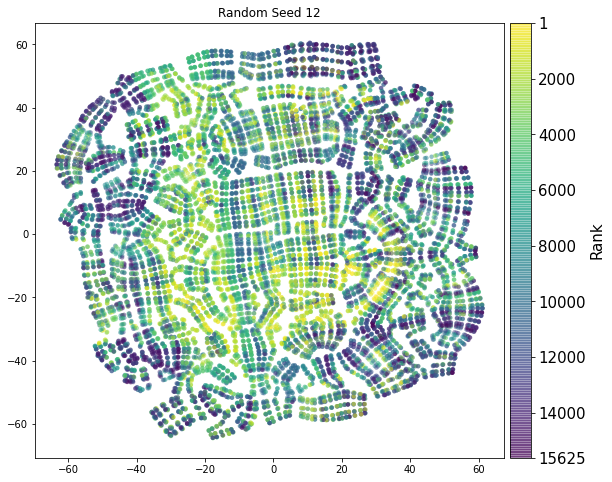

In [ ]:
args.dataset='cifar100'
args.setname='x-valid'
args.bench_path = 'nasbench201-cifar100-info.pth.tar'
url='https://www.dropbox.com/s/htc2gwr5pygksoo/nasbench201-cifar100-info.pth.tar?dl=1'
if not os.path.isfile(args.bench_path):
  download_url(url, model_dir='./', cached_file=args.bench_path)
bench_dict = torch.load(args.bench_path)
arch_array = np.array([arch for arch in bench_dict.keys()])
acc_array = np.array([get_dict(value, ['scratch', 'x-test', 'acc', 200, 'avg']) for value in bench_dict.values()])
random_state = 12
tsne = TSNE(random_state=random_state, n_components=2, perplexity=20, init='pca') #
X_embedded = tsne.fit_transform(arch_array)
x = X_embedded[:,0]
y = X_embedded[:,1]
rank = (-np.array(acc_array)).argsort().argsort() + 1
RANK = (-np.array(acc_array)).argsort().argsort() + 1
metric = RANK
fig, ax = plt.subplots(figsize=(10,8))
im = ax.scatter(x, y, edgecolors='none', c=metric, s=20, alpha=0.5, cmap='viridis_r')
cbar = fig.colorbar(im, ax=ax, pad=0.01)
cbar.set_ticks([1]+list(range(2000,15625,2000))+[15625])
cbar.set_label(label='Rank', size=15)
for t in cbar.ax.get_yticklabels():
  t.set_fontsize(15)
cbar.ax.invert_yaxis()
ax.set_title(f'Random Seed {random_state}')

Show WeakNAS Search Dynamic t-SNE

seed: 34366 runs 0
acc optimal: 73.51333332112631
0 sample space: 15625, sample space actual: 15625
1 sample space: 400, sample space actual: 398
2 sample space: 400, sample space actual: 381
3 sample space: 400, sample space actual: 372
4 sample space: 400, sample space actual: 350
optimal found !
5 sample space: 400, sample space actual: 320
optimal found !
6 sample space: 400, sample space actual: 298
optimal found !
7 sample space: 400, sample space actual: 265
optimal found !
8 sample space: 400, sample space actual: 237
optimal found !
9 sample space: 400, sample space actual: 202
optimal found !
10 sample space: 400, sample space actual: 182
optimal found !
plot 0
optimal 9930, pred 12862
optimal 9930, pred 1459
optimal 9930, pred 13714
optimal 9930, pred 9930


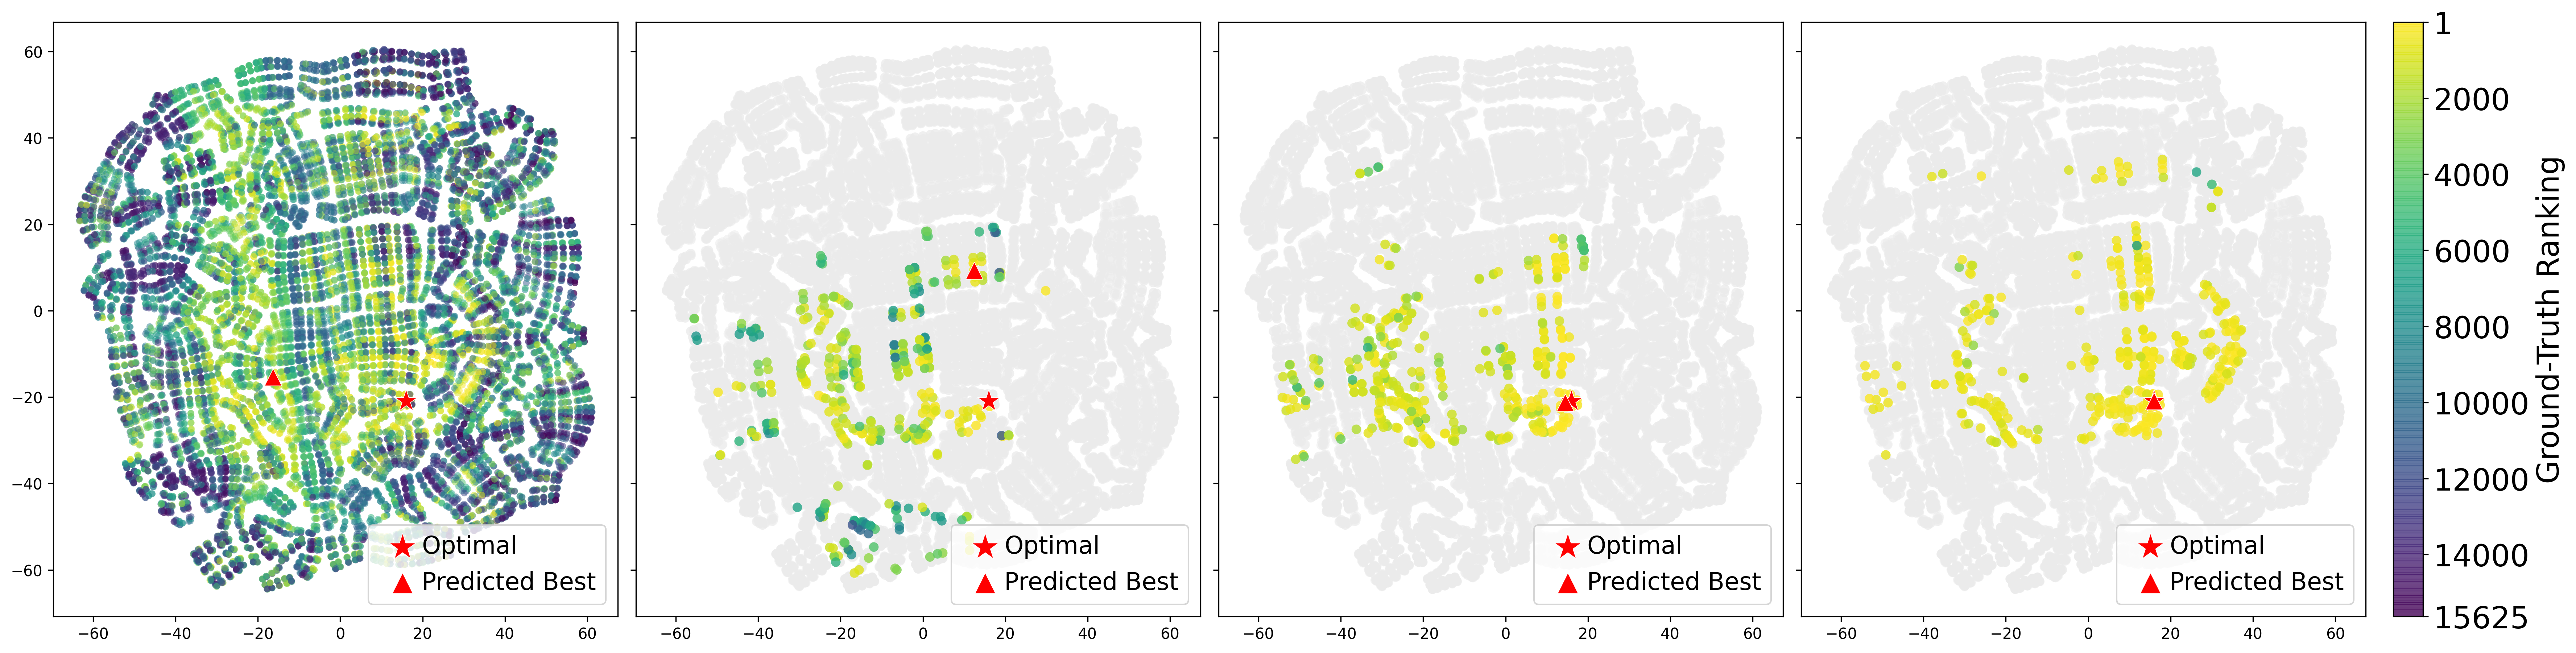

optimal 9930, pred 12862
optimal 9930, pred 1459
optimal 9930, pred 13714
optimal 9930, pred 9930


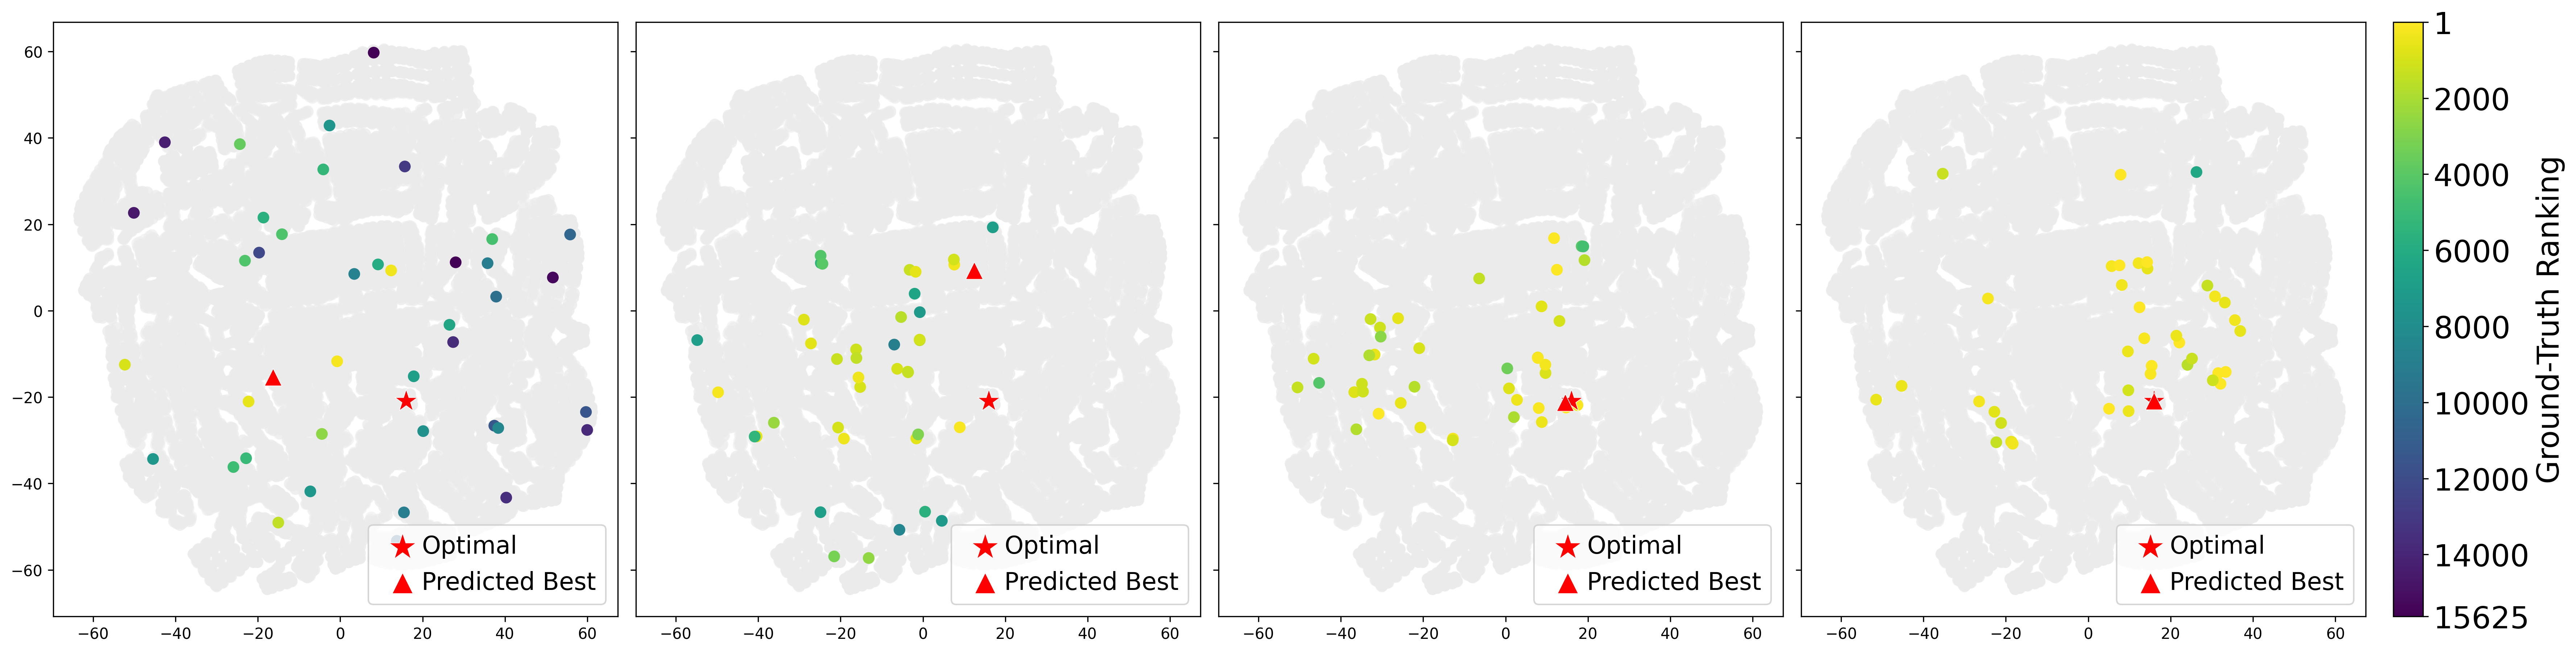

In [ ]:
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import rc
mpl.rcParams['figure.dpi'] = 300
args.label_key_dict = ['scratch', 'x-test', 'acc', 200, 'avg']
acc_list = [get_dict(value, args.label_key_dict) for i, (key, value) in enumerate(bench_dict.items())]
color_list = np.linspace(0.05, 0.95, 5)

args.top_list_acc = [400, 400, 400, 400, 400, 400, 400, 400, 400, 400, 400]
num_sample_train_list = [40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]

n_trees=50
max_depth=5

seed=34256+110
num_runs=1
name = 'plasma'
cmap = plt.get_cmap(name)(color_list)
i = 0
print(f'seed: {seed} runs {i}')
sample_list, sample_space_list, sample_space_exlude_list, \
rank_gt_list, rank_pred_list, acc_gt_list, acc_pred_list, \
index_optimal_list, predict_best_list \
= run_traj(seed=seed+i, args=args, dataset=args.dataset, setname=args.setname,
    num_sample=None, num_sample_train_list=num_sample_train_list, sampling_method=args.sampling_method, num_sample_method=args.num_sample_method,
    top_list_acc=args.top_list_acc, top_list_acc_delta=args.top_list_acc_delta, use_top_delta_acc=args.use_top_delta_acc,
    iteration=args.iteration, keep_old=args.keep_old, feature_list=args.feature_list, n_trees=n_trees, max_depth=max_depth,
    gaussian_std=args.gaussian_std, train_epoch=args.train_epoch, epoch=args.epoch, scratch_train_epoch=args.scratch_train_epoch, scratch_test_epoch=args.scratch_test_epoch,
    bench_dict=bench_dict, xlim=(67.5, 73.8), ylim=(67.6, 74.3), plot_size=100, plot_alpha=0.5, edf_x_lim=(26.4, 34), edf_top=200,
    num_plot_samples=1000, width=0.05, head_width=0.1, head_length=0.0, alpha_arrow=0.15, plot_all=True, legend=True, 
    figsize=(5,5), color_list=cmap, line_color='black', line_alpha=0.2, legend_scale=0.8,
    s_opt=250, s_pred=160, prob_top=50, stack=True, hide=True, rank=50, rank_size=280)
    
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(26,6), sharex=True, sharey=True)

subplot_title = ''

index_list = [0,1,2,10]
font_size = 20
size = 15
for j, index in enumerate(index_list):
  sample_l = sample_list[index]
  sample_space_l = sample_space_list[index]
  rank_gt_l = rank_gt_list[index]
  rank_pred_l = rank_pred_list[index]
  acc_gt_l = acc_gt_list[index]
  acc_pred_l = acc_pred_list[index]
  index_optimal_l = index_optimal_list[index]
  predict_best_l = predict_best_list[index]
  ax_ = ax[j]
  im = plot_traj(fig, ax_, X_embedded, sample_l, sample_space_l,\
            rank_gt_l, rank_pred_l, acc_gt_l, acc_pred_l,\
            index_optimal_l, predict_best_l, subplot_title, size, font_size, j, sample='space')

title = 'Ground-Truth Ranking'
fig.tight_layout()
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.01)
cbar.set_ticks([1]+list(range(2000,15625,2000))+[15625])
cbar.set_label(label=title, size=font_size)
for t in cbar.ax.get_yticklabels():
  t.set_fontsize(font_size)
cbar.ax.invert_yaxis()
plt.show()

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(26,6), sharex=True, sharey=True)

for j, index in enumerate(index_list):
  sample_l = sample_list[index]
  sample_space_l = sample_space_list[index]
  rank_gt_l = rank_gt_list[index]
  rank_pred_l = rank_pred_list[index]
  acc_gt_l = acc_gt_list[index]
  acc_pred_l = acc_pred_list[index]
  index_optimal_l = index_optimal_list[index]
  predict_best_l = predict_best_list[index]
  ax_ = ax[j]
  im = plot_traj(fig, ax_, X_embedded, sample_l, sample_space_l,\
            rank_gt_l, rank_pred_l, acc_gt_l, acc_pred_l,\
            index_optimal_l, predict_best_l, subplot_title, size, font_size, j, sample='sample')

title = 'Ground-Truth Ranking'
fig.tight_layout()
cbar = fig.colorbar(im, ax=ax.ravel().tolist(), pad=0.01)
cbar.set_ticks([1]+list(range(2000,15625,2000))+[15625])
cbar.set_label(label=title, size=font_size)
for t in cbar.ax.get_yticklabels():
  t.set_fontsize(font_size)
cbar.ax.invert_yaxis()
plt.show()